<a href="https://colab.research.google.com/github/center4ml/Workshops/blob/2023_2/Day_1/1_computational_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

## Automatic gradient functionality

When you design a neural network, we humans think in a forward manner: we want data to get into the network and pass through layers and we usually can visualise what transformations of the data can or should be applied so we achieve our goal. Thus, the design and then the implementation of the so called forward pass through a network is something we humans can naturally grasp in our minds.

But the way that neural networks are trained requires that all transformations of the forward pass, no matter how complex, are differentiated with respect to the weights of the neural network and all those gradients play then a role in weight update. The more complex were the transformations of the forward pass, the more complex will be the calculation of corresponding gradient functions. It is very inflexible, error prone and in some cases simply imposible or very hard to execute. It is a task for a machine.

The appearance of the dynamic expression tree building with automatic gradient calculation ability let us, humans, design only the forward pass (i.e. how the data is transformed in the neural network), while the engine of the framework takes care of correctly executing the backward pass. It gave the design of neural networks unseen flexibility and gave the whole Machine Learning field the boost we are experiencing nowadays.

One of the examples of frameworks that support dynamic expression tree building with automatic gradient calculation ability is PyTorch.

### What happens in a neural network

A neural network adjusts its weights in an iterative process called *backpropagation*:

- Let's say the loss value is computed in a *forward* pass through the network,
- Observe, that gradients calculated with respect to the particular weights on a loss function tell us, what is the impact of those particular weights on the loss: if the loss would increase or decrease if weights were increased or decreased by a tiny bit
- we exploit this in backpropagation: we want to decrease loss, so the weights of a neural network are adjusted from their current values *against* gradients calculated with respect to those weights on a loss function computed in a forward pass.
- *Gradients are computed where?* - the question occurs. At a multidimensional point equal to **the current values of the weights in a neural network**.

So, naturally, in the automatic differentiation engine, the gradients respective to a tensor will be computed in a point given by this tensor current value.

### First example

So let's see how it works in practice in PyTorch. We don't need a neural network to see it.

Let's have $f(x,y)=x^3+y^2$ as an example.
Then you can calculate by hand:

$\frac{\partial f(x,y)}{\partial x} = 3x^2, \frac{\partial f(x,y)}{\partial y} = 2y$

Concretely, as an example with which we will work some more:

$\frac{\partial f(x,y)}{\partial x} \Big|_{x=2} = 3 \cdot 2^2 = 12$

$\frac{\partial f(x,y)}{\partial y} \Big|_{y=4} = 2 \cdot 4 = 8$

You get all this automatically with PyTorch, which builds a tree of an expression that is constructed as we go. Let's have an example in Python code.

In [ ]:
x = torch.tensor([2.], requires_grad=True)   # we initiate the points with values
y = torch.tensor([4.], requires_grad=True)   # equal to where we want to compute
                                             # partial derivatives
pow3 = x ** 3
pow2 = y ** 2
f = pow3 + pow2                              # then we build the function

print('f:', f.grad_fn)
print('pow3:',pow3.grad_fn)
print('pow2:',pow2.grad_fn)


f: <AddBackward0 object at 0x7db338717af0>
pow3: <PowBackward0 object at 0x7db338716e30>
pow2: <PowBackward0 object at 0x7db338717af0>


The expression tree (which is used for computing gradients) gets built as we go, with leaves being the individual tensors we start from.

To calculate gradients numerically at the current tensor values you need to call `backward()`. Let's see if we get

$\frac{\partial f(x,y)}{\partial x} \Big|_{x=2} = 12$

$\frac{\partial f(x,y)}{\partial y} \Big|_{y=4} = 8$

as expected. The gradients of $f(x,y)$ with respect to variables $x$ and $y$ get written to a `grad` field of those variables (`x.grad`, `y.grad`). Why there, in the tree leaves? Again, because it is exactly where it is needed in backpropagation. Remember, in backpropagation we want to adjust the weights by changing the current weight values against the gradient, so having the computed gradient in the `grad` field makes the update very easy: it boild down to doing something like this:

`weight.value = weight.value - step_size * weight.grad`

In [ ]:
f.backward()
x.grad

tensor([12.])

In [ ]:
y.grad

tensor([8.])

OK, so far so good. But the weights in a neural network are not scalars, they are multidimensional entities, most commonly they are two dimensional matrices. In PyTorch, two dimensional matrices are called tensors of order two. What if $x$ and $y$ were tensors of order two? Let's have a look (building up our example a little bit)

$\frac{\partial f(x,y)}{\partial x} \Big|_{x=2} = 3 \cdot 2^2 = 12$

$\frac{\partial f(x,y)}{\partial x} \Big|_{x=3} = 3 \cdot 3^2 = 27$

$\frac{\partial f(x,y)}{\partial y} \Big|_{y=4} = 2 \cdot 4 = 8$

$\frac{\partial f(x,y)}{\partial y} \Big|_{y=5} = 2 \cdot 5 = 10$

In [ ]:
x = torch.tensor([[2., 3., 2.], [2., 3., 3.]], requires_grad=True)
y = torch.tensor([[4., 5., 5.], [4., 5., 5.]], requires_grad=True)
f = x**3 + y**2
print('f ==', f)
# f.backward() results in an error 'grad can be implicitly created only for scalar outputs`

f == tensor([[24., 52., 33.],
        [24., 52., 52.]], grad_fn=<AddBackward0>)


Well. Not good. You cannot call `backward()` on any other tensor than a scalar. And `f` is not a scalar. The reason behind it is that loss is always a scalar. Recall, that in backpropagation you adjust weights of a neural network according to gradients calculated with respect to those weights on a loss function (which results is a scalar).

Can we get around it? Let's try this:

In [ ]:
print('f.sum() ==',f.sum())

f.sum() == tensor(237., grad_fn=<SumBackward0>)


Recall, that to calculate gradients you need to call `backward()`, but you may call it on scalar variables only. But `f.sum()` is a scalar!

Let's try to call `backward()` on `f.sum()` scalar.

In [ ]:
f.sum().backward()
x.grad

tensor([[12., 27., 12.],
        [12., 27., 27.]])

In [ ]:
y.grad

tensor([[ 8., 10., 10.],
        [ 8., 10., 10.]])

OK, results are as expected (i.e. as calculated by hand earlier) coordinate-wise, i.e. on every coordinate separately.

### Explanation of this `sum()` trick

Let's examine `f` once more:

In [ ]:
print(f)

tensor([[24., 52., 33.],
        [24., 52., 52.]], grad_fn=<AddBackward0>)




The operations (powers and addition) work coordinate-wise, so in fact, for those tensors of order 2, and dimensions 2 by 3, we have that `f` is a matrix sized 2 by 3 of functions $f_{ij}$, each defined as $f_{ij} = x_{ij}^3 + y_{ij}^2$ and independent of **other** coordinates.

Consequently, a partial derivative of $f_{ij}$ with respect to say $x_{ij}$ is equal to a partial derivative of `f.sum()` with respect to $x_{ij}$, mathematically $ \frac{\partial f_{ij}}{\partial x_{ij}} = \frac{\partial \sum_{kl}f_{kl}}{\partial x_{ij}}$


**Note, that it works independently on number of orders of tensors in question nor on the particular order dimensions.**

### Another example

Now, let us consider another function.

$f(x,y)=xy$

$\frac{\partial f(x,y)}{\partial x} = y$

$\frac{\partial f(x,y)}{\partial y} = x$


In [ ]:
x = torch.tensor([[1., 2., 3.], [2., 4., 6.]], requires_grad=True)
y = torch.tensor([[3., 6., 9.], [-1., 1., 2.]], requires_grad=True)
f = x*y

print("f:", f.grad_fn)

f: <MulBackward0 object at 0x7db338716f80>


and the `sum()` trick:

In [ ]:
f.sum().backward()
x.grad

tensor([[ 3.,  6.,  9.],
        [-1.,  1.,  2.]])

In [ ]:
x.grad == y

tensor([[True, True, True],
        [True, True, True]])

Well, $\frac{\partial f}{\partial x} = y$ doesn't it?

### Enother example, this time with a computation graph on a blackboard



In [ ]:
x = torch.tensor([3.], requires_grad=True)
y = torch.tensor([2.], requires_grad=True)
f = x**2 * x * y

f.backward()

x.grad

tensor([54.])

**Now, let us draw the computational differentiation graph for this expression on a blackboard!**

## Your tasks

### Task 1

Your task is to calculate values of

$\frac{\partial f(x,y)}{\partial x} \Big|_{x=0.25, y=3.0}$

$\frac{\partial f(x,y)}{\partial y} \Big|_{x=0.25, y=3.0}$

$\frac{\partial f(x,y)}{\partial x} \Big|_{x=1.0, y=3.0}$

$\frac{\partial f(x,y)}{\partial y} \Big|_{x=1.0, y=3.0}$

for

$f(x,y)=\frac{sin(xy)}{sin(x)}$

**TIP:** in PyTorch, if `x` is a tensor, then `torch.sin(x)` is its sinus.

### Chart of that $\frac{\sin(xy)}{\sin(x)}$ function

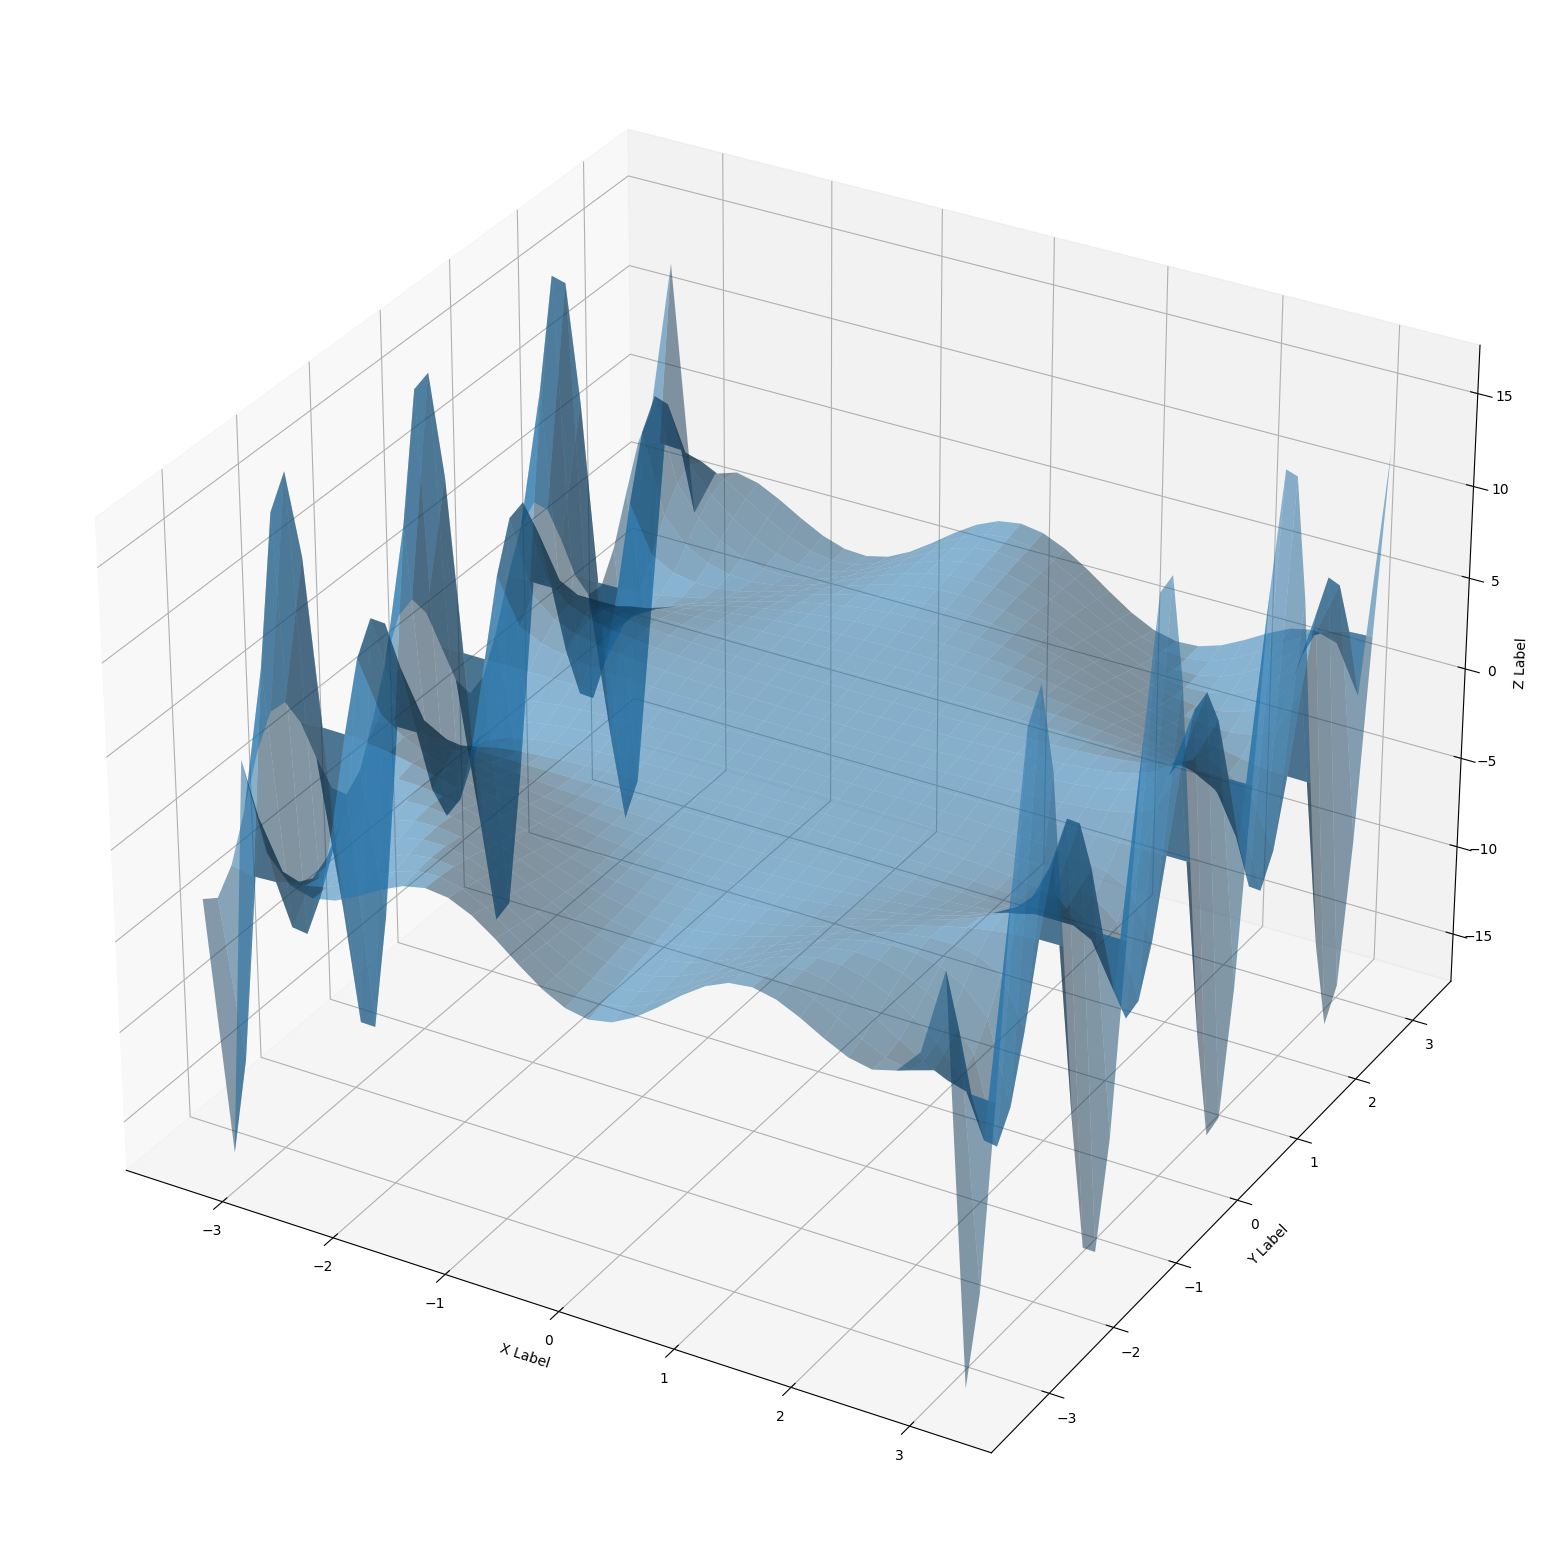

In [3]:
#from: https://stackoverflow.com/questions/8722735/i-want-to-use-matplotlib-to-make-a-3d-plot-given-a-z-function

def fun(x, y):
    return math.sin(x*y)/math.sin(x)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(-3.4, 3.4, 0.2)
X, Y = np.meshgrid(x, y)
zs = np.array([fun(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, alpha=0.5)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

### Task 2

Try to find on the above plot of the $f(x,y)$ function the points corresponding to the selected $x$ and $y$ coordinates and make sure that

- for $(x,y)=(0.25, 3.0)$ the rate of change in $x$ direction is negative while in $y$ direction it is positive,
- but if you move a little to the right to $(x,y)=(1.0, 3.0)$ the rate of change in both directions $x, y$ becomes negative.